In [1]:
import os
os.chdir("..")
from epilearn.models.SpatialTemporal import STGCN, ColaGNN
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast
import torch
import matplotlib.pyplot as plt
import numpy as np


## What your data looks like:

In [2]:
data = torch.load("example.pt")
data.keys()

dict_keys(['features', 'graph', 'dynamic_graph', 'targets', 'states'])

In [3]:
print(f"Node Features[time steps, nodes, channels]: {data['features'].shape}")
print(f"Static Graph[nodes, nodes]: {data['graph'].shape}")
print(f"Dynamic Graph[time steps, nodes, nodes]: {data['dynamic_graph'].shape}")
print(f"Prediction Target[time steps, nodes]: {data['targets'].shape}")
print(f"Nodes States[time steps, nodes]: {data['states'].shape}")

Node Features[time steps, nodes, channels]: torch.Size([539, 47, 4])
Static Graph[nodes, nodes]: (47, 47)
Dynamic Graph[time steps, nodes, nodes]: torch.Size([539, 47, 47])
Prediction Target[time steps, nodes]: torch.Size([539, 47])
Nodes States[time steps, nodes]: torch.Size([539, 47])


In [4]:
node_features = data['features']
static_graph = torch.Tensor(data['graph'])
dynamic_graph = data['dynamic_graph']
targets = data['targets']
node_status = data['states']

In this example, we also use the target time series as one of the channels.

In [5]:
(node_features[:,:, 0] != targets).sum()

tensor(0)

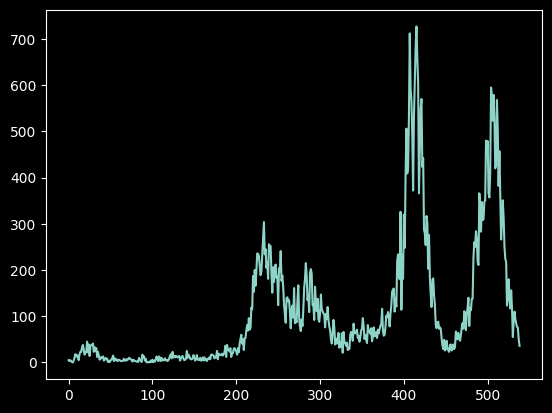

In [6]:
# first feature
plt.plot(np.array(node_features[:,0,0]))

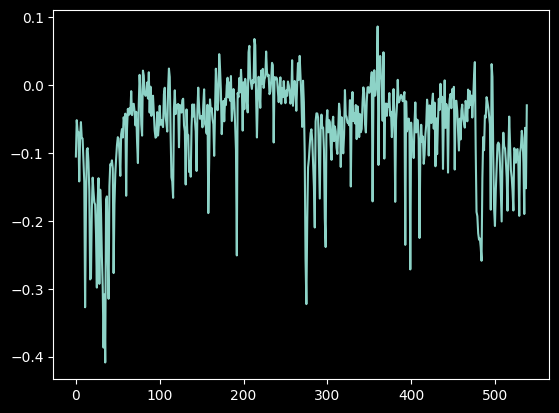

In [7]:
# second feature
plt.plot(np.array(node_features[:,0,1]))

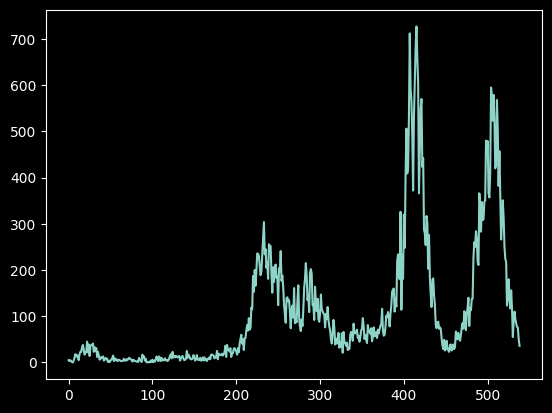

In [8]:
# prediction target
plt.plot(np.array(targets[:,0]))

## Loading your data into Epilearn dataset

Take spatial-temporal task as an example, we need ad least 1. node features; 2. target time series of every node; 3. graph (static or dynamic, depending on the model used)

In [9]:
dataset = UniversalDataset(x=node_features, 
                        #    states=node_status, # e.g. additional information of each node, e.g. SIR states
                           y=targets, # prediction target
                           graph=static_graph, # adjacency matrix, we also support edge index: edge_index = ...
                        #    dynamic_graph=dynamic_graph # # adjacency matrix
                           )

In [10]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=STGCN,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')
# model_args = {"num_features": 4, "num_timesteps_input": lookback, "num_timesteps_output":horizon, "num_nodes": 47}
# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=2,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          permute_dataset=True,
                        #   model_args=model_args
                          )

spatial-temporal model loaded!


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]




Final Training loss: 0.1328624167005744
Final Validation loss: 1.0381495952606201
Test MSE: 6.491805076599121
Test MAE: 1.9383817911148071
Test RMSE: 2.5479021072387695


In [11]:
# Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

Test MSE: 0.11567311733961105
Test MAE: 0.2004135400056839
Test RMSE: 0.3401075005531311


In [12]:
print(train_evaluation.keys())

dict_keys(['mse', 'mae', 'rmse', 'predictions', 'targets'])


In [13]:
print(train_evaluation['predictions'].shape)
print(train_evaluation['targets'].shape)

torch.Size([285, 47, 3])
torch.Size([285, 47, 3])


In [14]:
# when val_rate > 0
val_evaluation = task.evaluate_model(model=task.model,
                                 features=task.val_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.val_split['dynamic_graph'], 
                                 states=task.val_split['states'], 
                                 targets=task.val_split['targets'])

Test MSE: 1.0381495952606201
Test MAE: 0.7125993371009827
Test RMSE: 1.018896222114563


In [15]:
test_evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.test_split['dynamic_graph'], 
                                 states=task.test_split['states'], 
                                 targets=task.test_split['targets'])

Test MSE: 6.491805076599121
Test MAE: 1.9383817911148071
Test RMSE: 2.5479021072387695


### Temporal Task

As an example of temporal forecasting, we use a univariate time series as both feature and the target.

In [16]:
inputs = targets[:,0].unsqueeze(-1)
inputs.shape # length, channels

torch.Size([539, 1])

In [17]:
dataset = UniversalDataset(x=inputs, y=inputs)

In [18]:
from epilearn.models.Temporal import LSTMModel, DlinearModel, GRUModel
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=DlinearModel,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False)

temporal model loaded!


100%|██████████| 40/40 [00:00<00:00, 117.36it/s]



Final Training loss: 0.024256850191805925
Final Validation loss: 0.016341352835297585
Test MSE: 0.2753947377204895
Test MAE: 0.3812565505504608
Test RMSE: 0.5247806310653687


In [19]:
# for your customized model with unique parameters to initialize, please pass the parameters usinga a dict:
from epilearn.models.Temporal import LSTMModel, DlinearModel, GRUModel
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=DlinearModel,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')


# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output":horizon}

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False,
                          model_args=model_args) # pass the hyperparameters of your model


100%|██████████| 40/40 [00:00<00:00, 118.79it/s]



Final Training loss: 0.02705461869158575
Final Validation loss: 0.01680722087621689
Test MSE: 0.2787401080131531
Test MAE: 0.3868357241153717
Test RMSE: 0.5279584527015686


Test MSE: 0.02735336869955063
Test MAE: 0.10597159713506699
Test RMSE: 0.1653885394334793
dict_keys(['mse', 'mae', 'rmse', 'predictions', 'targets'])


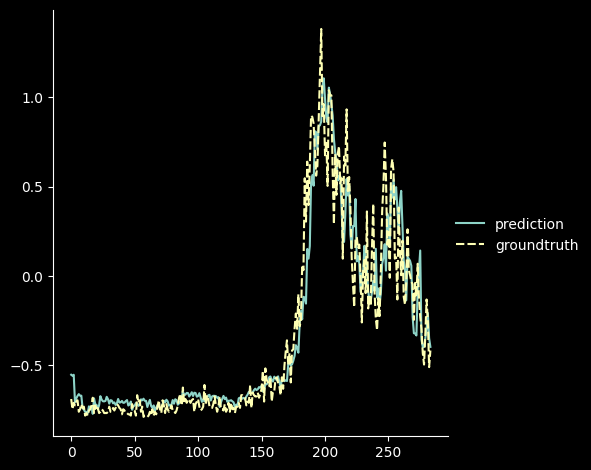

In [20]:
# Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 targets=task.train_split['targets'])
print(train_evaluation.keys())
train_results = task.plot_forecasts(dataset=task.train_dataset, index_range=[0,-1])

Test MSE: 0.2787401080131531
Test MAE: 0.3868357241153717
Test RMSE: 0.5279584527015686


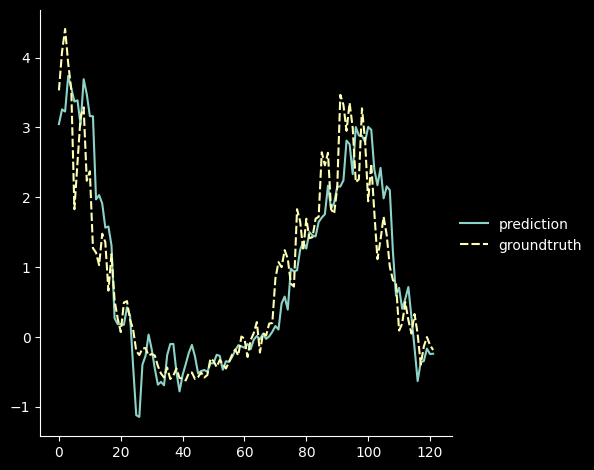

In [21]:
# Evaluation
evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 targets=task.test_split['targets'])
val_results = task.plot_forecasts(dataset=task.test_dataset, index_range=[0,-1])     

## Spatial Task

As an example of Spatial detection, we need 1. static graph; 2. node features 3. target of each node

### Spatial-Temporal data as input

In [22]:
graph = static_graph # nodes, nodes
features = torch.round(torch.rand((10,47,16,4))) # batch, nodes, time steps, channels
node_target = torch.round(torch.rand((10,47))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([47, 47])
features: torch.Size([10, 47, 16, 4])
node_target: torch.Size([10, 47])


Assuming we have binary class labels, and we want to do binary classification on each node

In [23]:
node_target

tensor([[0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
         0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
         0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
         0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.

In [24]:
print(f"node_target: {node_target.shape}")

node_target: torch.Size([10, 47])


In [25]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [26]:
from epilearn.tasks.detection import Detection
from epilearn.models.SpatialTemporal import STGCN

lookback = 16 # inputs size
horizon = 2 # predicts size; also seen as number of classes, here we have two classes: 0, 1

dataset.transforms = None
task = Detection(prototype=STGCN, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=True,
                          )

spatial-temporal model loaded!


100%|██████████| 25/25 [00:00<00:00, 60.36it/s]



Final Training loss: 0.40650925040245056
Final Validation loss: 0.7217626571655273
Test ACC: 0.5248227119445801


In [27]:
# Train Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

train_evaluation.keys()

ACC: 0.5921986103057861


dict_keys(['acc', 'predictions', 'targets'])

In [28]:
# Val Evaluation
val_evaluation = task.evaluate_model(model=task.model,
                                 features=task.val_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.val_split['dynamic_graph'], 
                                 states=task.val_split['states'], 
                                 targets=task.val_split['targets'])

ACC: 0.5744680762290955


In [29]:
# Val Evaluation
test_evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.test_split['dynamic_graph'], 
                                 states=task.test_split['states'], 
                                 targets=task.test_split['targets'])

ACC: 0.5248227119445801


### Spatial data as input

In [34]:
graph = static_graph # nodes, nodes
features = torch.round(torch.rand((10,47,1,4))) # batch, nodes, time steps=1, channels
node_target = torch.round(torch.rand((10,47))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([47, 47])
features: torch.Size([10, 47, 1, 4])
node_target: torch.Size([10, 47])


In [35]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [36]:
from epilearn.tasks.detection import Detection
from epilearn.models.Spatial.GCN import GCN

lookback = 1 # inputs size
horizon = 2 # predicts size; also seen as number of classes

dataset.transforms = None
task = Detection(prototype=GCN, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

# model_args={"num_features": 4, "hidden_dim": 16, "num_classes": 2, "nlayers": 2, "dropout": 0.5,
#             "with_bn": False, "with_bias": True, "device": 'cpu'}

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=False,
                        #   model_args=model_args
                          )

spatial model loaded!


100%|██████████| 25/25 [00:00<00:00, 152.97it/s]



Final Training loss: 0.6887664794921875
Final Validation loss: 0.7025765180587769

Predicting Progress...


100%|██████████| 3/3 [00:00<00:00, 819.52it/s]

Test ACC: 0.5319148898124695


In [37]:
# Train Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

train_evaluation.keys()


Predicting Progress...


100%|██████████| 6/6 [00:00<00:00, 351.72it/s]

ACC: 0.5709219574928284


dict_keys(['acc', 'predictions', 'targets'])